# Rag From Scratch:Routing

- 路由，主要解决的是从获取query之后，所需要执行的问题意图分类的问题，处理的是问题域选择问题：
- Routing的意义在于根据不同的问题类型走不同的策略，比如关系型数据库走nl2sql查询，向量查询走索引向量数据库查询。

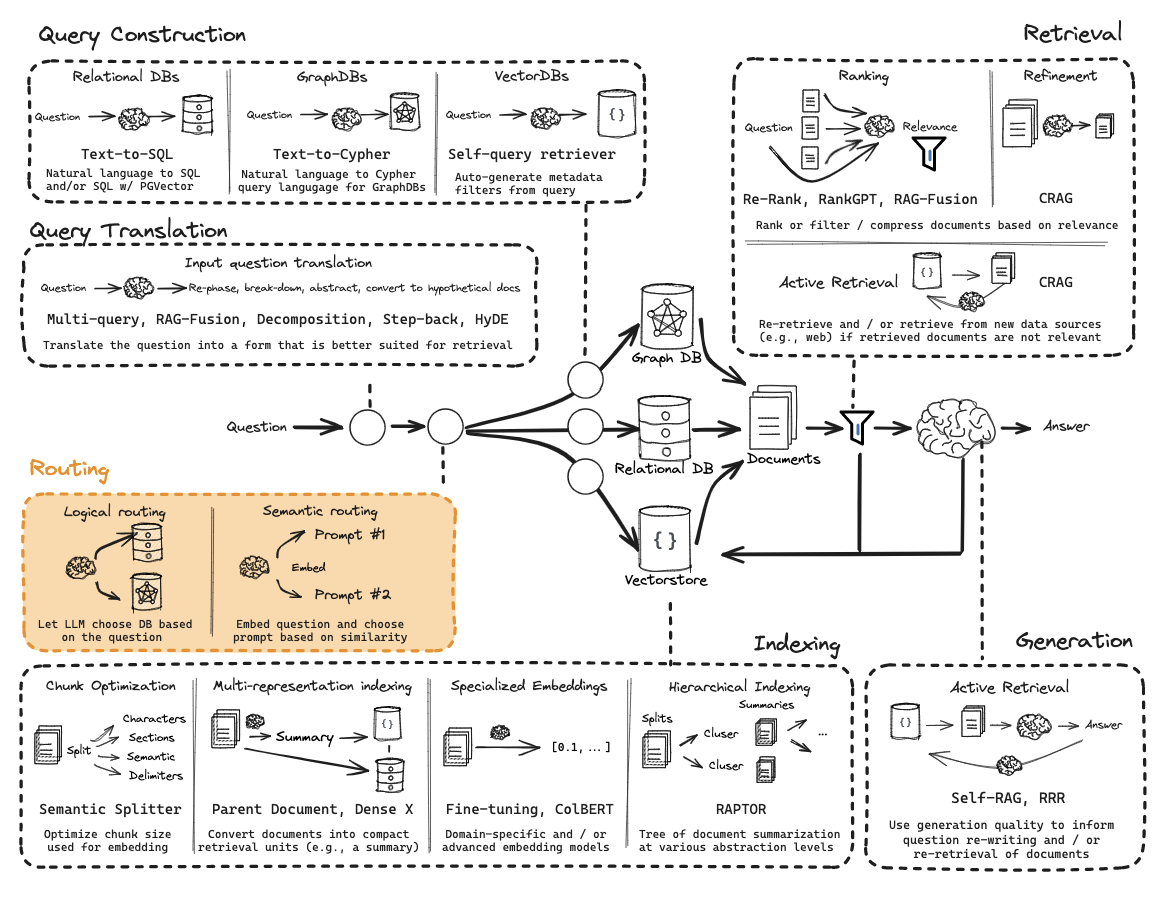

In [1]:
import os
from dotenv import find_dotenv, load_dotenv
_ = load_dotenv(find_dotenv())


os.environ['LANGCHAIN_TRACING_V2'] = 'true'
os.environ['LANGCHAIN_ENDPOINT'] = 'https://api.smith.langchain.com'

langchain_api_key=os.environ['langchain_api_key']

In [2]:
zhipu_api_key = os.environ['ZHIPUAI_API_KEY']
zhipu_api_key

## Part 10: Logical and Semantic routing
- Logical and Semantic routing，基于逻辑规则和语义的路由分发

Use function-calling for classification(使用函数调用进行分类)

Flow:
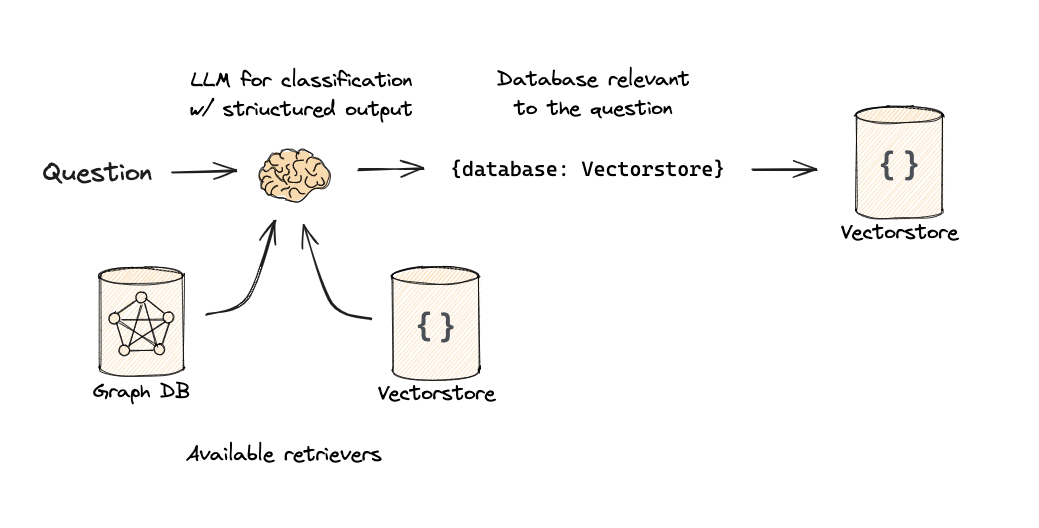

Docs:
- https://python.langchain.com/docs/use_cases/query_analysis/techniques/routing#routing-to-multiple-indexes

### Logical routing

In [3]:
from typing import Literal  # 类型提示，Literal为迭代器类型

from langchain_core.prompts import ChatPromptTemplate
from langchain_core.pydantic_v1 import BaseModel, Field
from langchain_community.chat_models import ChatZhipuAI
from langchain_community.embeddings import HuggingFaceEmbeddings

In [4]:
# Data Model
class RouteQuery(BaseModel):
    """Route a user query to the most relevant datasource."""

    datasource: Literal["python_docs", "js_docs", "golang_docs"] = Field(
        ...,
        description="Given a user question choose which datasource would be most relevant for answering their question",
    )
        
# LLM with function call


llm = ChatZhipuAI(model='glm-3-turbo', temperature=0.5, api_key=zhipu_api_key)
messages = [
    ("system", "你是一名专业的翻译家，可以将用户的中文翻译为英文。"),
    ("human", "我喜欢编程。"),
]
llm.invoke(messages)


AIMessage(content='I enjoy programming.', response_metadata={'token_usage': {'completion_tokens': 6, 'prompt_tokens': 23, 'total_tokens': 29}, 'model_name': 'glm-3-turbo', 'finish_reason': 'stop'}, id='run-71268e57-603d-4662-98ba-8ad1a621ce50-0')

In [5]:

# with_structured_output: 用于结构化输出
structured_llm = llm.with_structured_output(RouteQuery)

# Prompt
system = """You are an expert at routing a user question to the appropriate data source.

Based on the programming language the question is referring to, route it to the relevant data source.。
"""

prompt = ChatPromptTemplate.from_messages(
    [
        ("system", system),
        ("human", "{question}"),
    ]
)

# 定义路由
router = prompt | structured_llm

Note: we used function calling to produce structured output.

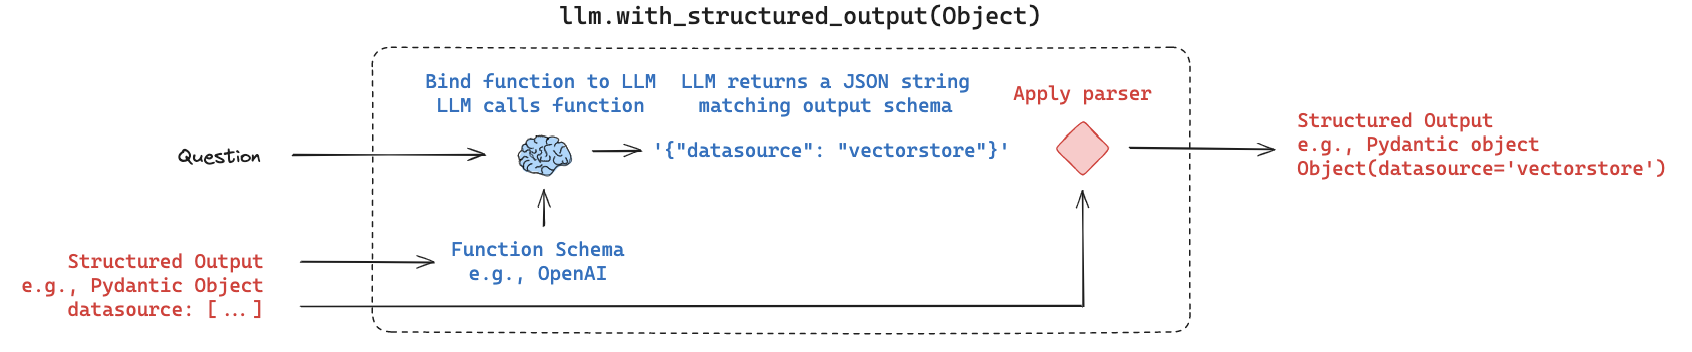Screenshot 2024-03-16 at 12.38.23 PM.png

In [7]:
question = """Why doesn't the following code work:

from langchain_core.prompts import ChatPromptTemplate

prompt = ChatPromptTemplate.from_messages(["human", "speak in {language}"])
prompt.invoke("french")
"""

result = router.invoke({"question": question})

result

RouteQuery(datasource='python_docs')

In [8]:
result.datasource

'python_docs'

Once we have this, it is trivial to define a branch that uses result.datasource

https://python.langchain.com/docs/expression_language/how_to/routing

In [9]:
def choose_route(result):
    if "python_docs" in result.datasource.lower():
        ### Logic here 
        return "chain for python_docs"
    elif "js_docs" in result.datasource.lower():
        ### Logic here 
        return "chain for js_docs"
    else:
        ### Logic here 
        return "golang_docs"

from langchain_core.runnables import RunnableLambda

full_chain = router | RunnableLambda(choose_route)

In [10]:
full_chain.invoke({"question": question})

'chain for python_docs'

### Semantic routing

- 基本思想：将问题和一组prompt向量化，让后计算其相似性选择合适的prompt。其实在前面问题优化中，问题在向量数据库中查询最接近答案的方式是一样的，只不过将向量数据库和相似度用于路由选择。步骤如下：

    - 将问题和一组事先准备好的prompt向量化
    - 对其问题与prompt直接计算相似度，取最相似的一个
    
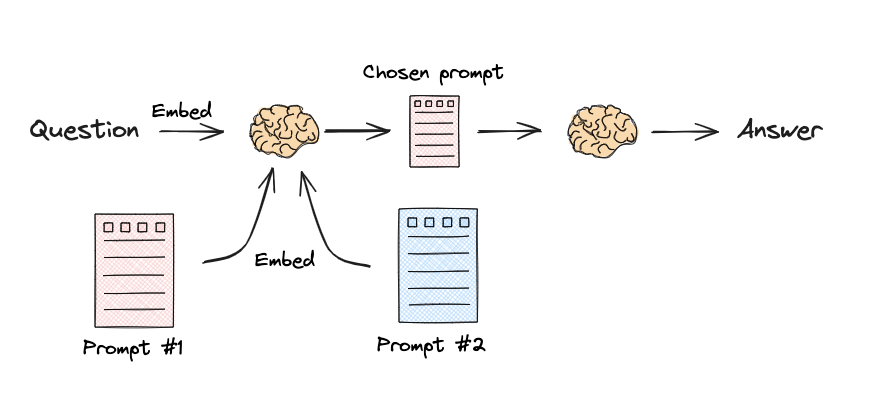 

Docs:
https://python.langchain.com/docs/expression_language/cookbook/embedding_router

In [12]:
from langchain.utils.math import cosine_similarity
from langchain_core.output_parsers import StrOutputParser
from langchain_core.prompts import PromptTemplate
from langchain_core.runnables import RunnablePassthrough, RunnableLambda
from langchain_community.embeddings import HuggingFaceEmbeddings

In [16]:
# Two prompts
physics_template = """You are a very smart physics professor. \
You are great at answering questions about physics in a concise and easy to understand manner. \
When you don't know the answer to a question you admit that you don't know.

Here is a question:
{query}"""

math_template = """You are a very good mathematician. You are great at answering math questions. \
You are so good because you are able to break down hard problems into their component parts, \
answer the component parts, and then put them together to answer the broader question.

Here is a question:
{query}"""


# Embed prompts
emb_model_path="D:/code/models/M3E/xrunda/m3e-base/"
embeddings = HuggingFaceEmbeddings(model_name=emb_model_path)
prompt_templates = [physics_template, math_template]
prompt_embeddings = embeddings.embed_documents(prompt_templates)

# ROute question to prompt
def prompt_router(input):
    # Embed question
    query_embedding = embeddings.embed_query(input['query'])
    
    # Compute similarity
    sim = cosine_similarity([query_embedding], prompt_embeddings)[0]
    most_similar = prompt_templates[sim.argmax()]
    
    # Choose prompt
    print(most_similar)
    print("Using MATH" if most_similar == math_template else "Using PHYSICS")
    return PromptTemplate.from_template(most_similar)


chain = (
    {"query": RunnablePassthrough()}
    | RunnableLambda(prompt_router)
    | llm
    | StrOutputParser()
)

print(chain.invoke("What's a black hole"))

You are a very smart physics professor. You are great at answering questions about physics in a concise and easy to understand manner. When you don't know the answer to a question you admit that you don't know.

Here is a question:
{query}
Using PHYSICS
A black hole is a region of space where the gravitational pull is so strong that nothing, not even light, can escape from it. This occurs because the black hole has a very high mass but is compressed into an incredibly small space, which requires a lot of energy to maintain. The event horizon is the boundary beyond which nothing can escape, and it's the point of no return. Black holes are often formed from the remnants of a star that has run out of nuclear fuel and collapsed under its own gravity.


# Rag From Scratch: Query Construction(查询转换)
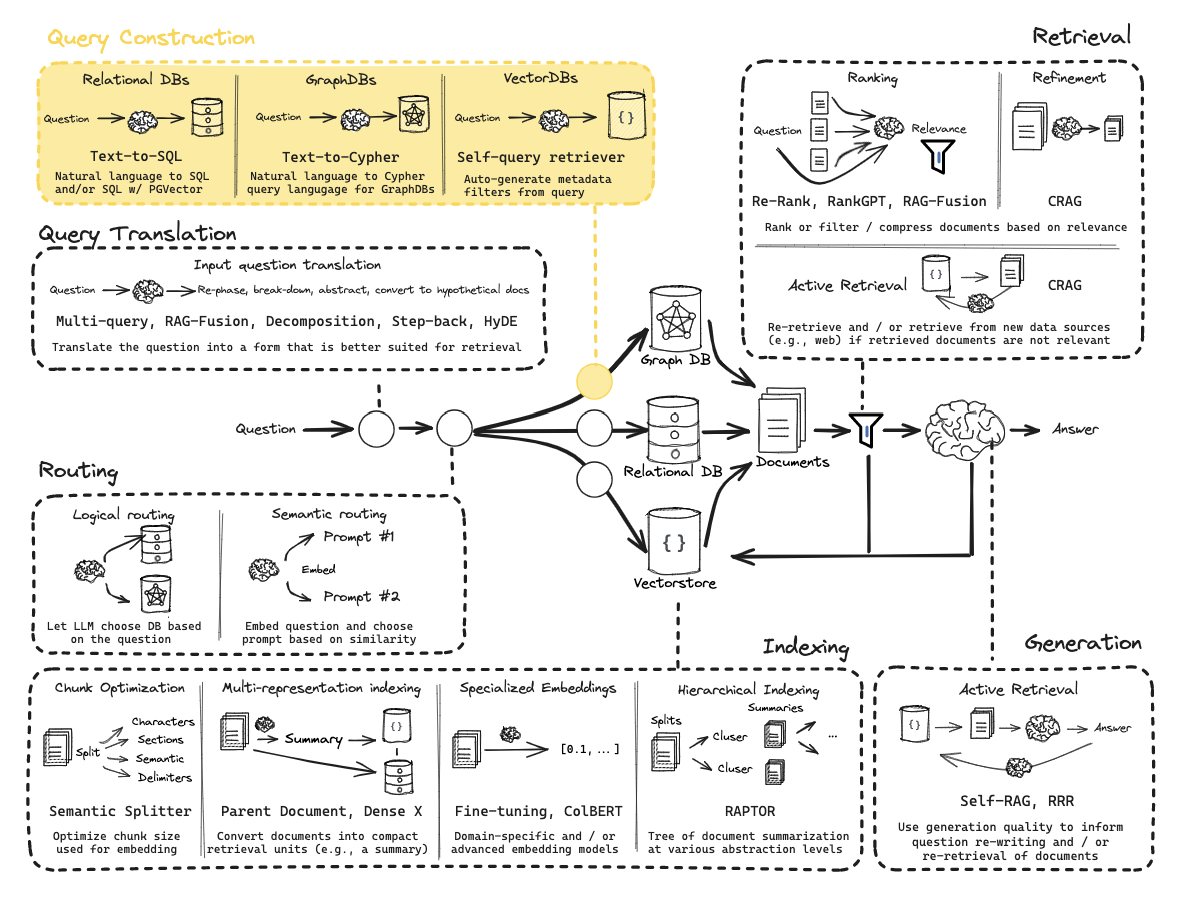

- Query construction就是将自然语言查询转换为与之交互的数据库的查询语言。

https://blog.langchain.dev/query-construction/

https://blog.langchain.dev/enhancing-rag-based-applications-accuracy-by-constructing-and-leveraging-knowledge-graphs/

## Part11: Query structuring for metedata filters
- Text-to-metadata-filter
- 检索中最重要的步骤之一是将输入文本转化为正确的查询和filter参数，即提取query中的结构化参数。当前许多向量库都包含元数据字段，这使得基于元数据过滤特定的chunk成为可能

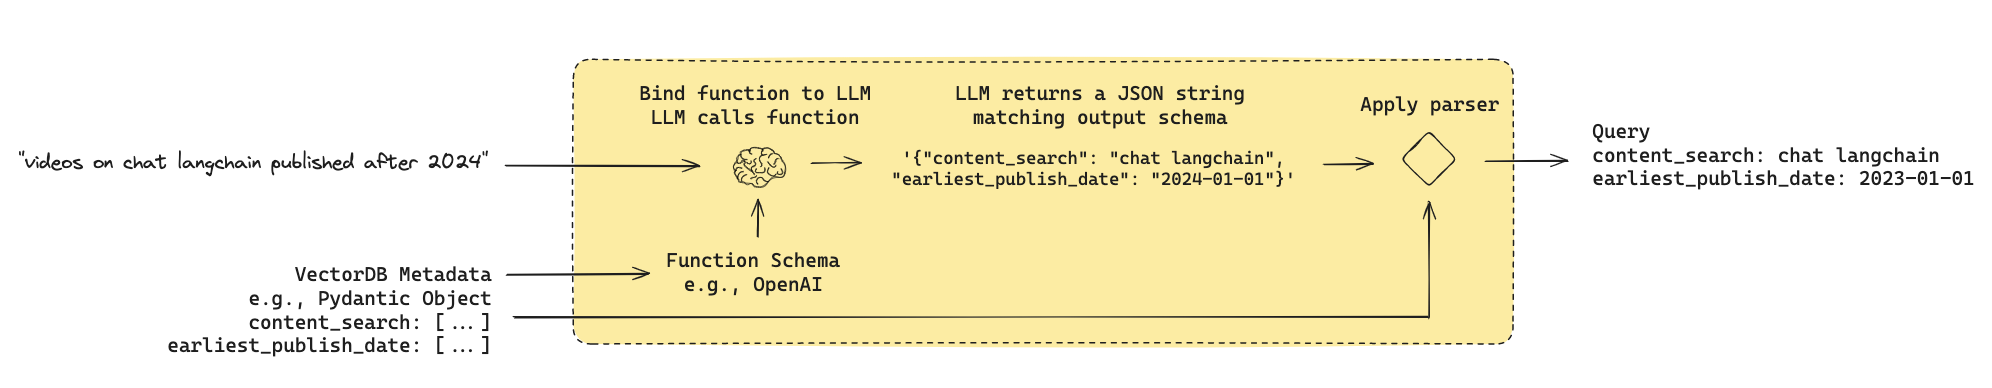

Query structuring for metadata filters，基于元数据过滤器的问题构建，例如，许多向量化存储都包含元数据字段，例如：
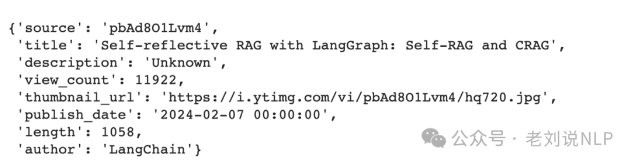

这样就可以根据元数据过滤特定的数据chunk：https://python.langchain.com/docs/use_cases/query_analysis/techniques/structuring

In [42]:
# ! pip install youtube-transcript-api
# ! pip install pytube

from langchain_community.document_loaders import YoutubeLoader

docs = YoutubeLoader.from_youtube_url(
    "https://www.youtube.com/watch?v=pbAd8O1Lvm4", add_video_info=True
).load()

print(len(docs))

print(docs[0].metadata)

URLError: <urlopen error [WinError 10060] 由于连接方在一段时间后没有正确答复或连接的主机没有反应，连接尝试失败。>

假设我们建立了一个索引：

1. 允许我们对每个文档的内容和标题进行非结构化搜索
2. 并对视图计数、发布日期和长度使用范围过滤。

我们希望将自然语言转换为结构化搜索查询。

我们可以为结构化搜索查询定义一个模式。

In [32]:
import datetime
from typing import Literal, Optional, Tuple
from langchain_core.pydantic_v1 import BaseModel, Field

class TutorialSearch(BaseModel):
    """Search over a database of tutorial videos about a software library."""
    
    content_search: str = Field(
        ...,
        description="Similarity search query applied to video transcripts."
    )
    title_search: str = Field(
        ...,
         description=(
            "Alternate version of the content search query to apply to video titles. "
            "Should be succinct and only include key words that could be in a video "
            "title."
    )
    min_view_count: Optional[int] = Field(
        None,
        description="Minimum view count filter, inclusive. Only use if explicitly specified.",
    )
    max_view_count: Optional[int] = Field(
        None,
        description="Maximum view count filter, exclusive. Only use if explicitly specified.",
    )
    earliest_publish_date: Optional[datetime.date] = Field(
        None,
        description="Earliest publish date filter, inclusive. Only use if explicitly specified.",
    )
    latest_publish_date: Optional[datetime.date] = Field(
        None,
        description="Latest publish date filter, exclusive. Only use if explicitly specified.",
    )
    min_length_sec: Optional[int] = Field(
        None,
        description="Minimum video length in seconds, inclusive. Only use if explicitly specified.",
    )
    max_length_sec: Optional[int] = Field(
        None,
        description="Maximum video length in seconds, exclusive. Only use if explicitly specified.",
    )

    def pretty_print(self) -> None:
        for field in self.__fields__:
            if getattr(self, field) is not None and getattr(self, field) != getattr(
                self.__fields__[field], "default", None
            ):
                print(f"{field}: {getattr(self, field)}")

SyntaxError: '(' was never closed (3061238509.py, line 12)

Now, we prompt the LLM to produce queries.

In [33]:
from langchain_core.prompts import ChatPromptTemplate

system = """
You are an expert at converting user questions into database queries. \
You have access to a database of tutorial videos about a software library for building LLM-powered applications. \
Given a question, return a database query optimized to retrieve the most relevant results.

If there are acronyms or words you are not familiar with, do not try to rephrase them.
"""
prompt = ChatPromptTemplate.from_messages(
    {
        ("system": system),
        ("human": "{question}")
    }
)

structured_llm = llm.with_structured_output(TutorialSearch)
query_analyzer = prompt | structured_llm

SyntaxError: invalid syntax (2507631066.py, line 12)

In [34]:
query_analyzer.invoke({"question": "rag from scratch"}).pretty_print()

NameError: name 'query_analyzer' is not defined

In [35]:
query_analyzer.invoke(
    {"question": "videos on chat langchain published in 2023"}
).pretty_print()

NameError: name 'query_analyzer' is not defined

In [36]:
query_analyzer.invoke(
    {"question": "videos that are focused on the topic of chat langchain that are published before 2024"}
).pretty_print()

NameError: name 'query_analyzer' is not defined

In [37]:
query_analyzer.invoke(
    {
        "question": "how to use multi-modal models in an agent, only videos under 5 minutes"
    }
).pretty_print()

NameError: name 'query_analyzer' is not defined

## Query Construction for Text-to-SQL

https://zhuanlan.zhihu.com/p/687874199

关系型数据库是结构化数据的重要来源，将自然语言转化为SQL请求存在以下挑战：

- 幻觉：LLM容易对虚构的表或字段产生“幻觉”，从而创建无效的查询。需要确保LLM生成与实际数据库schema一致的有效SQL。
- 用户错误：Text-to-SQL方法应该对用户拼写错误或用户输入中可能导致无效查询的其他不规则性具有鲁棒性。

为了应对这些挑战，下面是一些实用的技巧：
- 数据库描述：要生成SQL查询，必须向LLM提供数据库的准确描述。有几篇论文提到了一种常见的text-to-SQL prompt采用的方法：为LLM提供每张表的CREATE TABLE描述，包括列名、类型等，然后再给出三个SELECT语句的示例。
- Few-shot样例：在prompt中添加question-query的几个样例可以提高query生成的准确性。在prompt中简单的添加标准的静态示例指导agent如何基于question创建query。
- 错误处理：当遇到错误时，利用工具（例如SQL agent）修复错误。
- 查找专有名词中的拼写错误：当查询名称等专有名词时，用户可能会不小心写错。我们允许agent根据向量库搜索正确的名称，向量库在SQL数据库中存储相关专有名词的正确拼写
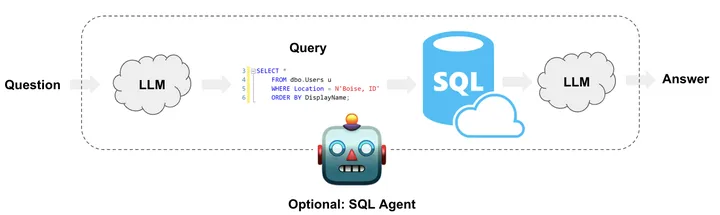

### Chain方法

将问题转化为SQL查询

SQL chain或agent的第一步是接受用户输入并将其转换为SQL查询。LangChain为此提供了一个内置链：create_sql_query_chain。

In [48]:
from langchain_community.utilities import SQLDatabase

db = SQLDatabase.from_uri("sqlite:///Chinook.db")

from langchain.chains import create_sql_query_chain

chain = create_sql_query_chain(llm, db)
response = chain.invoke({"question": "How many employees are there"})
response

'Question: How many employees are there?\nSQLQuery: SELECT COUNT(*) FROM "employees";\nSQLResult:'

In [49]:
db.run(response)

OperationalError: (sqlite3.OperationalError) near "Question": syntax error
[SQL: Question: How many employees are there?
SQLQuery: SELECT COUNT(*) FROM "employees";
SQLResult:]
(Background on this error at: https://sqlalche.me/e/14/e3q8)

### Agent方法

LangChain提供了SQL Agent，一种更灵活的与SQL数据库交互的方式。使用SQL Agent的主要优点是：

- 它可以根据数据库的schema以及数据库的内容（如描述特定的表）回答问题。
- 它可以通过运行生成的query、捕获traceback 并重新正确生成以便于从修正错误。
- 它可以回答需要多个相关查询的问题。
- 它只考虑相关表的schema，以此来节省token。

我们使用create_sql_agent函数初始化agent，此agent包含SQLDatabaseToolkit，其中包含用于执行以下操作的工具：

- 创建和执行query
- query语法检查
- 检索表描述
- 其他的一些工具

初始化agent

In [62]:
from langchain_community.agent_toolkits import create_sql_agent

agent_executor = create_sql_agent(llm, db=db, agent_type="openai-tools", verbose=True)

agent_executor.invoke(
    {
        "input": "List the total sales per country. Which country's customers spent the most?"
    }
)



> Entering new SQL Agent Executor chain...
```python
tool_call(table_names='orders, customers')
```

> Finished chain.


{'input': "List the total sales per country. Which country's customers spent the most?",
 'output': "```python\ntool_call(table_names='orders, customers')\n```"}

## Query Construction for Text-to-Cypher
虽然向量存储很容易处理非结构化数据，但它们不了解向量之间的关系。而SQL数据库可以建模关系，但更改schema可能会造成破坏而且代价巨大。知识图谱通过建模数据之间的关系，扩展关系类型可以解决这些问题，而无需进行重大修改。知识图谱适用于具有难以用表格形式表示的多对多关系或层次结构的数据。

与关系型数据库通常使用SQL一样，图数据库通常使用Cypher进行查询。Text-to-Cypher可以将自然语言转化为 Cypher查询：

In [66]:
# ! pip install neo4j

from langchain.chains import GraphCypherQAChain
from langchain_community.graphs import Neo4jGraph

graph = Neo4jGraph(
    url="bolt://localhost:7687", username="neo4j", password="pleaseletmein"
)

graph.refresh_schema()

chain = GraphCypherQAChain.from_llm(
    llm, graph=graph, verbose=True
)

ValueError: Could not connect to Neo4j database. Please ensure that the url is correct

In [67]:
chain.run("Who played in Top Gun?")

AttributeError: 'RunnableSequence' object has no attribute 'run'